# 1. Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from datetime import datetime

import xgboost as xgb
from sklearn.metrics import *
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.dummy import DummyRegressor
from sklearn.inspection import permutation_importance
tqdm.pandas()

from src.helpers import get_project_dir, load_model, save_model
from src.functions_and_methods import custom_score, group, eval, cross_validate_, Selector, get_new_feats

import warnings
warnings.filterwarnings("ignore")

# 2. Importing Data

In [167]:
df = pd.read_csv(os.path.join(get_project_dir(), 'data/train_data.csv')).rename(columns={'timestamp': 'date'})
df_v = pd.read_csv(os.path.join(get_project_dir(), 'data/validation_data.csv')).rename(columns={'hour': 'date'})

In [168]:
# Timestamp -> Datetime
tqdm.pandas()
df['date'] = df['date'].progress_apply(lambda x: datetime.utcfromtimestamp(x))
df = df.sort_values(by='date')
df_v['date'] = df_v['date'].progress_apply(lambda x: datetime.utcfromtimestamp(x))
df_v = df_v.sort_values(by='date')

  0%|          | 0/8526526 [00:00<?, ?it/s]

  0%|          | 0/686 [00:00<?, ?it/s]

# 3. Outliers detection

##  3.1. lon & lat (with DBSCAN)

### Initial detection (train set)

In [169]:
points1 = df.drop_duplicates(subset='point')[['point','lon','lat']] \
           .sort_values(by='lon')

 0    7024
-1      17
Name: cluster, dtype: int64


<Axes: xlabel='lon', ylabel='lat'>

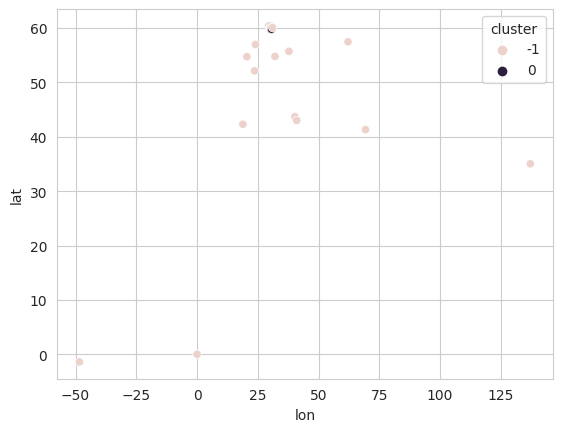

In [170]:
outlier_detection = DBSCAN(
  eps = 0.5,
  metric="euclidean",
  min_samples = 10,
  n_jobs = -1)
clusters = outlier_detection.fit_predict(points1[['lon','lat']])
points1['cluster'] = clusters
print(points1['cluster'].value_counts())

sns.scatterplot(data=points1, x='lon', y='lat', hue='cluster')

<Axes: xlabel='lon', ylabel='lat'>

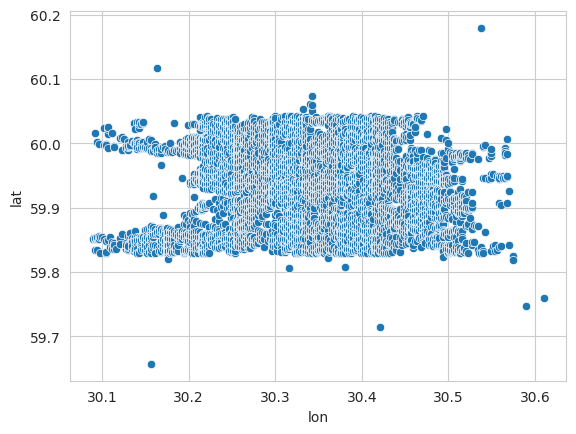

In [171]:
points2 = points1[points1['cluster']==0]
sns.scatterplot(data=points2, x='lon', y='lat')

### Secondary detection (train set)

 0    6950
-1      44
 2      18
 1      12
Name: cluster, dtype: int64


<Axes: xlabel='lon', ylabel='lat'>

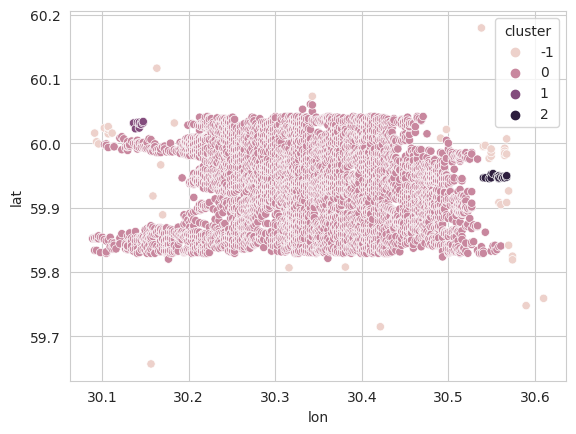

In [172]:
outlier_detection = DBSCAN(
  eps = 0.015,
  metric="euclidean",
  min_samples = 10,
  n_jobs = -1)
clusters = outlier_detection.fit_predict(points2[['lon','lat']])
points2['cluster'] = clusters
print(points2['cluster'].value_counts())

sns.scatterplot(data=points2, x='lon', y='lat', hue='cluster')

<Axes: xlabel='lon', ylabel='lat'>

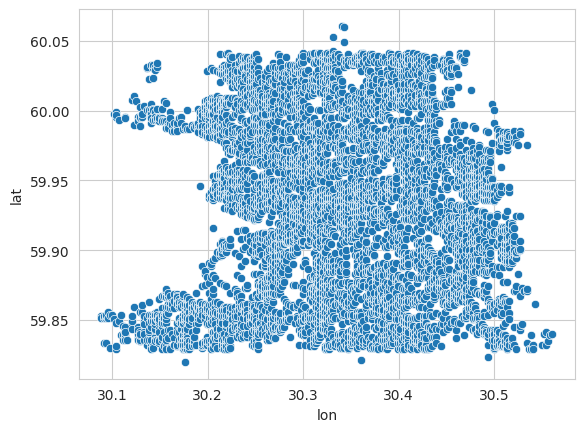

In [173]:
points3 = points2[points2['cluster'].isin([0, 1])]
sns.scatterplot(data=points3, x='lon', y='lat')

In [174]:
print(f'Initial number of points: {len(points1)}')
print(f'Resulting number of points: {len(points3)}')
print(f'Number of outliers: {len(points1) - len(points3)}')
print(f'% of outliers: {round((len(points1) - len(points3))/len(points1)*100,1)}')

Initial number of points: 7041
Resulting number of points: 6962
Number of outliers: 79
% of outliers: 1.1


In [175]:
df2 = df[df['point'].isin(points3['point'])]
print(f'Initial number of observations: {len(df)}')
print(f'Resulting number of observations: {len(df2)}')
print(f'Number of outliers: {len(df) - len(df2)}')
print(f'% of outliers: {round((len(df) - len(df2))/len(df)*100,1)}')

Initial number of observations: 8526526
Resulting number of observations: 8444501
Number of outliers: 82025
% of outliers: 1.0


## 3.2. Isolation Forest (not included)

In [26]:
feats = ['lon', 'lat', 'likescount', 'commentscount', 'symbols_cnt', 'words_cnt', 'hashtags_cnt', 'mentions_cnt', 'links_cnt', 'emoji_cnt']
clf = IsolationForest(n_estimators=100, random_state=42, n_jobs=-1).fit(df2[feats])

In [27]:
df2['is_not_outlier'] = clf.predict(df2[feats])

In [28]:
df2['is_not_outlier'].value_counts()

 1    7552170
-1     892331
Name: is_not_outlier, dtype: int64

In [29]:
df3 = df2[df2['is_not_outlier']==1].drop('is_not_outlier', axis=1)
print(f'Initial number of observations: {len(df)}')
print(f'Resulting number of observations: {len(df3)}')
print(f'Number of outliers: {len(df) - len(df3)}')
print(f'% of outliers: {round((len(df) - len(df3))/len(df)*100,1)}')

Initial number of observations: 8526526
Resulting number of observations: 7552170
Number of outliers: 974356
% of outliers: 11.4


# 4. Aggregating data (via mean values)

## Train set

In [176]:
df4 = group(df2)
df4

,point,date,likescount_sum,count,commentscount_sum,symbols_cnt_sum,words_cnt_sum,hashtags_cnt_sum,mentions_cnt_sum,links_cnt_sum,emoji_cnt_sum,lon_mean,lat_mean
0,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,2019-11-22 11:00:00,31,1,3,270,24,5,1,0,0,30.116020,59.835705
1,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,2019-11-22 12:00:00,37,1,4,358,31,4,0,0,1,30.116020,59.835705
2,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,2019-11-23 13:00:00,34,1,0,119,7,4,0,0,0,30.116020,59.835705
3,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,2019-11-25 16:00:00,45,1,2,244,16,4,1,0,0,30.116020,59.835705
4,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,2019-11-27 10:00:00,42,1,2,242,18,4,0,0,1,30.116020,59.835705
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3621312,0101000020E6100000FF9D4C0EC3853E4094782B2D0DF3...,2019-12-06 04:00:00,6,2,0,51,6,0,0,0,2,30.522508,59.898840
3621313,0101000020E6100000FF9D4C0EC3853E4094782B2D0DF3...,2019-12-23 08:00:00,3317,1,10,56,9,0,0,0,3,30.522508,59.898840
3621314,0101000020E6100000FF9D4C0EC3853E40ABD94A1972EF...,2019-06-10 09:00:00,40,1,1,96,5,1,0,0,1,30.522508,59.870670
3621315,0101000020E6100000FF9D4C0EC3853E40ABD94A1972EF...,2019-10-06 14:00:00,26,1,0,0,0,0,0,0,0,30.522508,59.870670


In [13]:
df4.to_csv(os.path.join(get_project_dir(), 'data/d2/train_data2.csv'), index=False)

# 5. Feature Engineering (new time-based features)

## Time based features

### Train

In [ ]:
df = pd.read_csv(os.path.join(get_project_dir(), 'data/d2/train_data2.csv'))

In [ ]:
df['date'] = df['date'].astype('datetime64')
df['new'] = df['date'].progress_apply(lambda x: get_new_feats(x))
feats = ['hour', 'day', 'month', 'year', 'is_night', 'is_evening', 'is_morning', 'is_day',
         'weekday', 'is_weekend', 'is_holiday', 'is_working_day', 'temp']
df[feats] = pd.DataFrame(df['new'].tolist(), index=df.index)
df = df.drop('new', axis=1) \
       .rename(columns={'lon_mean': 'lon', 'lat_mean': 'lat'})

In [19]:
df.to_csv(os.path.join(get_project_dir(), 'data/d2/train_data3.csv'), index=False)

### Val

In [12]:
df_v = pd.read_csv(os.path.join(get_project_dir(), 'data/validation_data.csv')).rename(columns={'hour': 'date'})
df_v['date'] = df_v['date'].progress_apply(lambda x: datetime.utcfromtimestamp(x))
df_v = df_v.sort_values(by='date') \
           .rename(columns={'sum': 'count'})

  0%|          | 0/686 [00:00<?, ?it/s]

In [13]:
df_v['date'] = df_v['date'].astype('datetime64')
df_v['new'] = df_v['date'].progress_apply(lambda x: get_new_feats(x))
feats = ['hour', 'day', 'month', 'year', 'is_night', 'is_evening', 'is_morning', 'is_day',
         'weekday', 'is_weekend', 'is_holiday', 'is_working_day', 'temp']
df_v[feats] = pd.DataFrame(df_v['new'].tolist(), index=df_v.index)
df_v = df_v.drop('new', axis=1)

  0%|          | 0/686 [00:00<?, ?it/s]

# 6. Feature Generation (for validation data based on training data)

In [14]:
df = pd.read_csv(os.path.join(get_project_dir(), 'data/d2/train_data3.csv'))

In [15]:
df_lag = df.groupby(['point', 'hour', 'month', 'weekday'], as_index=False) \
             .agg({'likescount_sum': 'mean',
                   'commentscount_sum': 'mean',
                   'symbols_cnt_sum': 'mean',
                   'mentions_cnt_sum': 'mean',
                   'links_cnt_sum': 'mean',
                   'emoji_cnt_sum': 'mean',
                   'words_cnt_sum': 'mean',
                   'hashtags_cnt_sum': 'mean'})

In [16]:
df_v = df_v.merge(df_lag, how='left')

In [17]:
df_v.to_csv(os.path.join(get_project_dir(), 'data/d2/val_data3.csv'), index=False)

# 7. Dummy Regressor

In [18]:
target = 'count'
eval(DummyRegressor(strategy="mean"), df, df_v, ['lat'], target)

train R2 = 0.0
train custom = 0.7515452698328723
val R2 = -1.3510861596062074
val custom = 3.2233597548830164


# 8. XGBoost

In [180]:
params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42}

In [2]:
df = pd.read_csv(os.path.join(get_project_dir(), 'data/d2/train_data3.csv'))
df_v = pd.read_csv(os.path.join(get_project_dir(), 'data/d2/val_data3.csv'))

## Only lan, lot, temp and time-based features (better results)

In [20]:
feats = ['lon', 'lat',
       'hour', 'day', 'month', 'year', 'is_night', 'is_evening', 'is_morning',
       'is_day', 'weekday', 'is_weekend', 'is_holiday', 'is_working_day',
       'temp']
target = 'count'

In [27]:
scores = cross_validate_(model=xgb.XGBRegressor, params=params, X=df[feats], y=df[target],
                         cv=5, scoring={'R2': r2_score, 'custom': custom_score}, random_state=42)

  0%|          | 0/5 [00:00<?, ?it/s]

train cv R2 = 0.4498539942794898
train cv custom = 0.46591070512123833


In [21]:
eval(xgb.XGBRegressor(**params), df, df_v, feats, target)

train R2 = 0.44654426811734027
train custom = 0.5079223347946692
val R2 = 0.018408150168209514
val custom = 1.1758492508081133


## All features (worse results)

In [22]:
feats = ['likescount_sum', 'commentscount_sum',
       'symbols_cnt_sum', 'words_cnt_sum', 'hashtags_cnt_sum',
       'mentions_cnt_sum', 'links_cnt_sum', 'emoji_cnt_sum', 'lon', 'lat',
       'hour', 'day', 'month', 'year', 'is_night', 'is_evening', 'is_morning',
       'is_day', 'weekday', 'is_weekend', 'is_holiday', 'is_working_day',
       'temp']
target = 'count'

In [30]:
scores = cross_validate_(model=xgb.XGBRegressor, params=params, X=df[feats], y=df[target],
                         cv=5, scoring={'R2': r2_score, 'custom': custom_score}, random_state=42)

  0%|          | 0/5 [00:00<?, ?it/s]

train cv R2 = 0.8508982720166351
train cv custom = 0.3095614184146225


In [23]:
eval(xgb.XGBRegressor(**params), df, df_v, feats, target)

train R2 = 0.868402341137995
train custom = 0.2998096436579136
val R2 = -0.4003463008773718
val custom = 1.4435864980028936


# 9. Feature selection (permutation importance)

## lat, lon, temp and time-based feats (better results)

In [24]:
feats = ['lon', 'lat', 'hour', 'day', 'month', 'year', 'is_night', 'is_evening', 'is_morning',
         'is_day', 'weekday', 'is_weekend', 'is_holiday', 'is_working_day', 'temp']
target = 'count'
model = xgb.XGBRegressor(**params)
model.fit(df[feats], df[target])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [25]:
r = permutation_importance(model, df_v[feats], df_v[target], n_repeats=50, random_state=42)

In [26]:
imps = pd.DataFrame()
imps['feat'] = feats
imps['importance'] = r.importances_mean
imps = imps.sort_values(by='importance', ascending=False)
imps

,feat,importance
0,lon,1.099132
1,lat,1.059698
2,hour,0.074443
13,is_working_day,0.010978
12,is_holiday,0.003989
14,temp,0.002634
9,is_day,0.001678
3,day,0.000676
10,weekday,0.000234
4,month,0.000000


In [27]:
eval(xgb.XGBRegressor(**params), df, df_v, imps['feat'].tolist()[:], target)

train R2 = 0.44654426811734027
train custom = 0.5079223347946692
val R2 = 0.01897981741747512
val custom = 1.1751683114567382


In [29]:
# This set of feature will be used !!!
eval(xgb.XGBRegressor(**params), df, df_v, imps['feat'].tolist()[:13], target)

train R2 = 0.4452965804028509
train custom = 0.4343394284799055
val R2 = -0.0002604224664850552
val custom = 1.1390349656313783


In [30]:
eval(xgb.XGBRegressor(**params), df, df_v, imps['feat'].tolist()[:11], target)

train R2 = 0.44630827378843063
train custom = 0.48675462997469415
val R2 = -0.005299602983088292
val custom = 1.1539272850750961


In [31]:
eval(xgb.XGBRegressor(**params), df, df_v, imps['feat'].tolist()[:9], target)

train R2 = 0.43301323054542507
train custom = 0.4786338316758992
val R2 = -0.2042691089980897
val custom = 1.3989212919377738


## All features (worse results)

In [32]:
feats = ['likescount_sum', 'commentscount_sum', 'symbols_cnt_sum', 'words_cnt_sum', 'hashtags_cnt_sum',
       'mentions_cnt_sum', 'links_cnt_sum', 'emoji_cnt_sum', 'lon', 'lat', 'hour', 'day', 'month', 'year', 'is_night', 'is_evening', 'is_morning',
       'is_day', 'weekday', 'is_weekend', 'is_holiday', 'is_working_day', 'temp']
target = 'count'
model = xgb.XGBRegressor(**params)
model.fit(df[feats], df[target])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [33]:
r = permutation_importance(model, df_v[feats], df_v[target], n_repeats=50, random_state=42)

In [34]:
imps = pd.DataFrame()
imps['feat'] = feats
imps['importance'] = r.importances_mean
imps = imps.sort_values(by='importance', ascending=False)
imps

,feat,importance
0,likescount_sum,0.139924
8,lon,0.083438
9,lat,0.057613
2,symbols_cnt_sum,0.050207
21,is_working_day,0.047033
10,hour,0.043797
3,words_cnt_sum,0.043790
1,commentscount_sum,0.034037
18,weekday,0.004713
22,temp,0.000369


In [35]:
eval(xgb.XGBRegressor(**params), df, df_v, imps['feat'].tolist()[:], target)

train R2 = 0.868402341137995
train custom = 0.2998096436579136
val R2 = -0.40147704812581986
val custom = 1.4438377759698042


In [36]:
eval(xgb.XGBRegressor(**params), df, df_v, imps['feat'].tolist()[:21], target)

train R2 = 0.8516696060445952
train custom = 0.3093458956085403
val R2 = -0.446301174478408
val custom = 1.445790954208741


In [37]:
eval(xgb.XGBRegressor(**params), df, df_v, imps['feat'].tolist()[:19], target)

train R2 = 0.8380906660461224
train custom = 0.2940017604373314
val R2 = -0.43152190401704105
val custom = 1.4611367927710623


In [38]:
eval(xgb.XGBRegressor(**params), df, df_v, imps['feat'].tolist()[:17], target)

train R2 = 0.8382814220086585
train custom = 0.27420099095448475
val R2 = -0.42879365186754104
val custom = 1.436010033488193


In [39]:
eval(xgb.XGBRegressor(**params), df, df_v, imps['feat'].tolist()[:15], target)

train R2 = 0.8378704573242016
train custom = 0.28875916582041716
val R2 = -0.4398562567585016
val custom = 1.4404359922246883


In [40]:
eval(xgb.XGBRegressor(**params), df, df_v, imps['feat'].tolist()[:13], target)

train R2 = 0.8378704573242016
train custom = 0.28875916582041716
val R2 = -0.4398562567585016
val custom = 1.4404359922246883


# 10. Feature selection (correlation) (not included)

In [8]:
feats1 = ['lon', 'lat', 'hour', 'day', 'month', 'year', 'is_night', 'is_evening', 'is_morning',
          'is_day', 'weekday', 'is_weekend', 'is_holiday', 'is_working_day', 'temp']
feats2 = ['likescount_sum', 'commentscount_sum', 'symbols_cnt_sum', 'words_cnt_sum', 'hashtags_cnt_sum',
          'mentions_cnt_sum', 'links_cnt_sum', 'emoji_cnt_sum']

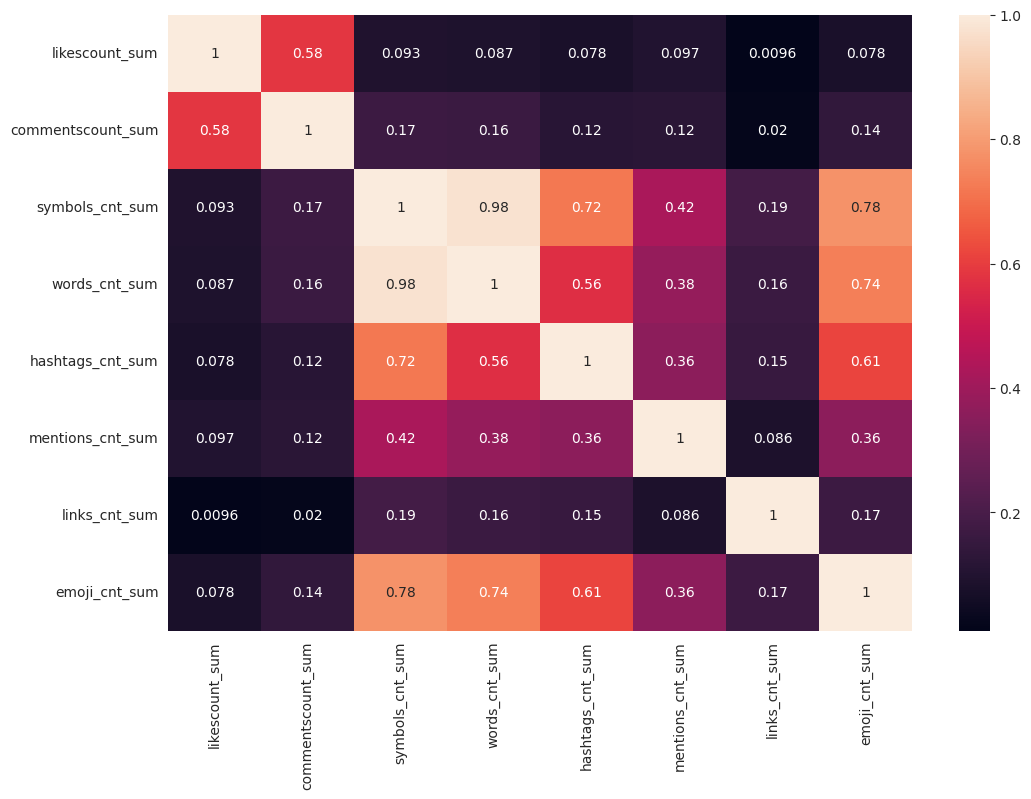

In [15]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[feats2].corr(), annot = True)
plt.show()

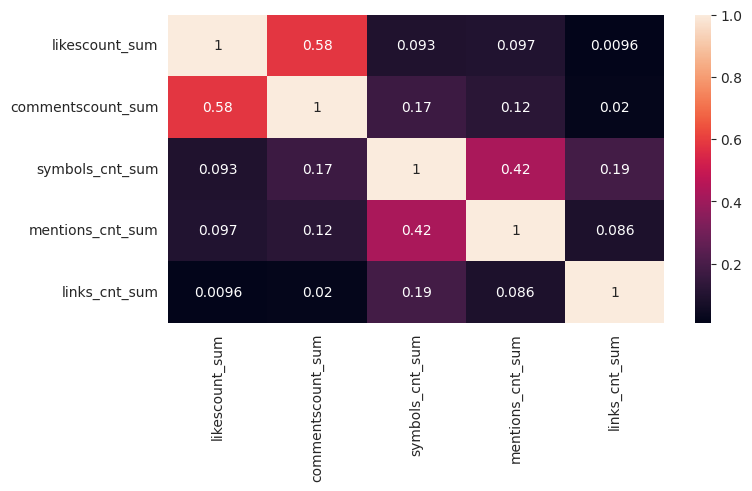

In [8]:
# Excluding: words_cnt_sum, emoji_cnt_sum, hashtags_cnt_sum
feats2 = ['likescount_sum', 'commentscount_sum', 'symbols_cnt_sum', 'mentions_cnt_sum', 'links_cnt_sum']
plt.figure(figsize=(8, 4))
sns.heatmap(df[feats2].corr(), annot = True)
plt.show()

# 11. Feature selection (Greedy Search) (not included)

In [3]:
target = 'count'
default_features = ['lon', 'lat', 'hour', 'day', 'month', 'year', 'is_night', 'is_evening', 'is_morning',
          'is_day', 'weekday', 'is_weekend', 'is_holiday', 'is_working_day', 'temp']
features_to_select = ['likescount_sum', 'commentscount_sum', 'symbols_cnt_sum', 'mentions_cnt_sum', 'links_cnt_sum']

In [5]:
selector = Selector()
best_feats, best_score = selector.search(df=df, df_v=df_v, feats_to_select=features_to_select,
                                         default_feats=default_features, target=target,
                                         model=xgb.XGBRegressor, params=params, scorer=custom_score,
                                         max_steps=2)

Forward
----------------------------------------------------------------------
last_turn: 0, best_score: 100, best_feats_cnt: 0, curr_feats: []
new_feat: likescount_sum, score: 1.2506037603841487
UPDATING best set
best_feats: ['likescount_sum'], best_score: 1.2506037603841487
----------------------------------------------------------------------
last_turn: 0, best_score: 1.2506037603841487, best_feats_cnt: 1, curr_feats: ['likescount_sum']
new_feat: commentscount_sum, score: 1.236377366943159
UPDATING best set
best_feats: ['likescount_sum', 'commentscount_sum'], best_score: 1.236377366943159
----------------------------------------------------------------------
last_turn: 0, best_score: 1.236377366943159, best_feats_cnt: 2, curr_feats: ['likescount_sum', 'commentscount_sum']
new_feat: links_cnt_sum, score: 1.2467839239352383
No improvement
----------------------------------------------------------------------
last_turn: 0, best_score: 1.236377366943159, best_feats_cnt: 2, curr_feats: [

In [3]:
params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
target = 'count'
default_features = ['lon', 'lat', 'hour', 'is_working_day', 'is_holiday', 'temp', 'is_day', 'day', 'weekday',
 'month', 'year', 'is_night', 'is_evening']
features_to_select = ['is_morning', 'is_weekend', 'commentscount_sum',
                      'symbols_cnt_sum', 'mentions_cnt_sum', 'links_cnt_sum',
                      'likescount_sum', 'words_cnt_sum', 'emoji_cnt_sum', 'hashtags_cnt_sum']

In [ ]:
selector = Selector()
best_feats, best_score = selector.search(df=df, df_v=df_v, feats_to_select=features_to_select,
                                         default_feats=default_features, target=target,
                                         model=xgb.XGBRegressor, params=params, scorer=custom_score,
                                         max_steps=4, initial_direction='forward', init_score=1.1390349656313783)

Forward
----------------------------------------------------------------------
last_turn: 0, best_score: 1.1390349656313783, best_feats_cnt: 0, curr_feats: []
new_feat: likescount_sum, score: 1.5760570528770537
No improvement
----------------------------------------------------------------------
last_turn: 0, best_score: 1.1390349656313783, best_feats_cnt: 0, curr_feats: ['likescount_sum']
new_feat: words_cnt_sum, score: 1.5220962476171818
No improvement
----------------------------------------------------------------------
last_turn: 0, best_score: 1.1390349656313783, best_feats_cnt: 0, curr_feats: ['likescount_sum', 'words_cnt_sum']
new_feat: is_morning, score: 1.5220962476171818
No improvement
----------------------------------------------------------------------
last_turn: 0, best_score: 1.1390349656313783, best_feats_cnt: 0, curr_feats: ['likescount_sum', 'words_cnt_sum', 'is_morning']


In [9]:
selector = Selector()
best_feats, best_score = selector.search(df=df, df_v=df_v, feats_to_select=features_to_select,
                                         default_feats=default_features, target=target,
                                         model=xgb.XGBRegressor, params=params, scorer=custom_score,
                                         max_steps=3)

Forward
----------------------------------------------------------------------
last_turn: 0, best_score: 100, best_feats_cnt: 0, curr_feats: []
new_feat: likescount_sum, score: 1.9143901539673567
UPDATING best set
best_feats: ['likescount_sum'], best_score: 1.9143901539673567
----------------------------------------------------------------------
last_turn: 0, best_score: 1.9143901539673567, best_feats_cnt: 1, curr_feats: ['likescount_sum']
new_feat: year, score: 1.5765574292103466
UPDATING best set
best_feats: ['likescount_sum', 'year'], best_score: 1.5765574292103466
----------------------------------------------------------------------
last_turn: 0, best_score: 1.5765574292103466, best_feats_cnt: 2, curr_feats: ['likescount_sum', 'year']
new_feat: lat, score: 1.5531836114017337
UPDATING best set
best_feats: ['likescount_sum', 'year', 'lat'], best_score: 1.5531836114017337
----------------------------------------------------------------------
last_turn: 0, best_score: 1.55318361140173

# 12. Hyperparameters optimization (see VM2.ipynb)

In [4]:
feats = ['lon', 'lat', 'hour', 'is_working_day', 'is_holiday', 'temp', 'is_day', 'day', 'weekday',
 'month', 'year', 'is_night', 'is_evening']
target = 'count'
best_set1 = {'learning_rate': 1,
  'max_depth': 8,
  'n_estimators': 800,
  'lambda': 1,
  'alpha': 1,
  'n_jobs': -1,
  'random_state': 42}
best_set2 = {'learning_rate': 0.4641588833612777,
             'max_depth': 17,
             'n_estimators': 800,
             'lambda': 10.0,
             'alpha': 0.09999999999999999,
             'colsample_bytree': 0.9,
             'subsample': 0.6,
             'min_child_weight': 264,
             'random_state': 42,
             'n_jobs': -1,}
best_set3 = {'lambda': 0.16681005372000587,
             'alpha': 0.16681005372000587,
             'colsample_bytree': 0.7,
             'subsample': 0.6,
             'learning_rate': 0.8499999999999999,
             'n_estimators': 800,
             'max_depth': 13,
             'random_state': 42}

# 13. Results for the best models

## Best set 1: val: 0.03156019975700219, train: 0.49503709046208094

In [5]:
eval(xgb.XGBRegressor(**best_set1), df, df_v, feats, target)

train R2 = 0.827626675035155
train custom = 0.49503709046208094
val R2 = -0.21352920028393907
val custom = 0.03156019975700219


In [6]:
model = xgb.XGBRegressor(**best_set1)
model.fit(df[feats], df[target])

XGBRegressor(alpha=1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=1, learning_rate=1,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=800, n_jobs=-1, ...)

In [7]:
save_model(model=model, filename='model1.pkl')

In [8]:
df_v['pred'] = model.predict(df_v[feats])
df_v['score'] = np.abs(df_v['pred'] - df_v['count']) / df_v['pred']
df_v_sorted = df_v[['count', 'pred', 'score']].sort_values(by='score')

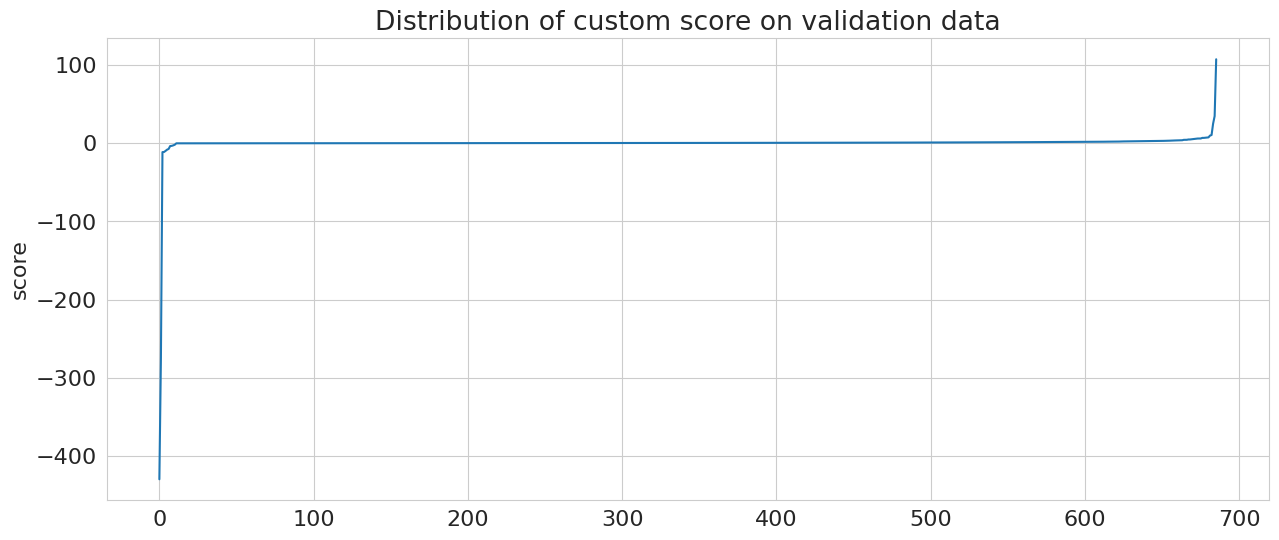

In [228]:
plt.figure(figsize=(15, 6))
sns.lineplot(x=range(len(df_v_sorted)), y=df_v_sorted['score'])
plt.title('Distribution of custom score on validation data')
plt.show()

In [190]:
points = df_v.groupby('point') \
             .agg({'lat': 'mean',
                   'lon': 'mean',
                   'score': 'mean'}) \
             .sort_values(by='score')
points_train = df[['point', 'lon', 'lat']].groupby('point') \
                                          .agg({'lon': 'mean',
                                                'lat': 'mean'})

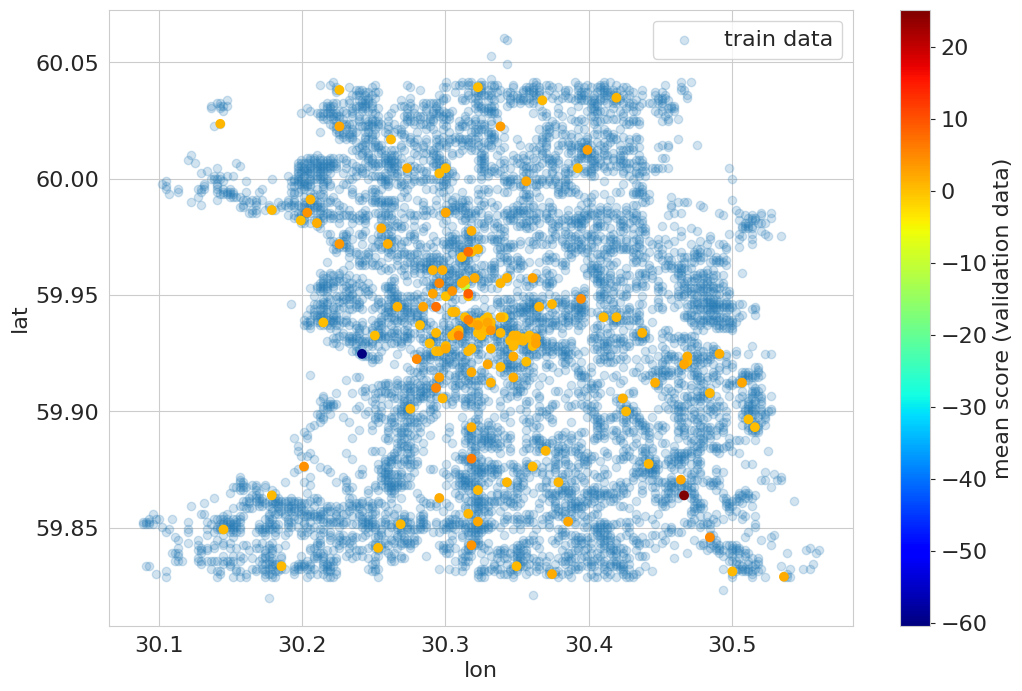

In [229]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(12, 8))
plt.scatter(points_train['lon'], points_train['lat'], alpha=0.2, label='train data')
plt.scatter(points['lon'], points['lat'], c=points['score'], cmap='jet')
plt.ylabel('lat')
plt.xlabel('lon')
plt.legend()
cbar = plt.colorbar(label='mean score (validation data)')

## Best set 2: val: 0.04429821032394422, train: 0.23231352936419913

In [29]:
eval(xgb.XGBRegressor(**best_set2), df, df_v, feats, target)

train R2 = 0.8511426525256958
train custom = 0.23231352936419913
val R2 = 0.096392797234222
val custom = 0.04429821032394422


In [30]:
model = xgb.XGBRegressor(**best_set2)
model.fit(df[feats], df[target])

XGBRegressor(alpha=0.09999999999999999, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=10.0,
             learning_rate=0.4641588833612777, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=17, max_leaves=None,
             min_child_weight=264, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=800, n_jobs=-1, ...)

In [32]:
save_model(model=model, filename='model2.pkl')

In [33]:
df_v['pred'] = model.predict(df_v[feats])
df_v['score'] = np.abs(df_v['pred'] - df_v['count']) / df_v['pred']
df_v_sorted = df_v[['count', 'pred', 'score']].sort_values(by='score')

In [35]:
df_v.to_csv(os.path.join(get_project_dir(), 'data/d2/predictions/predictions2.csv'))

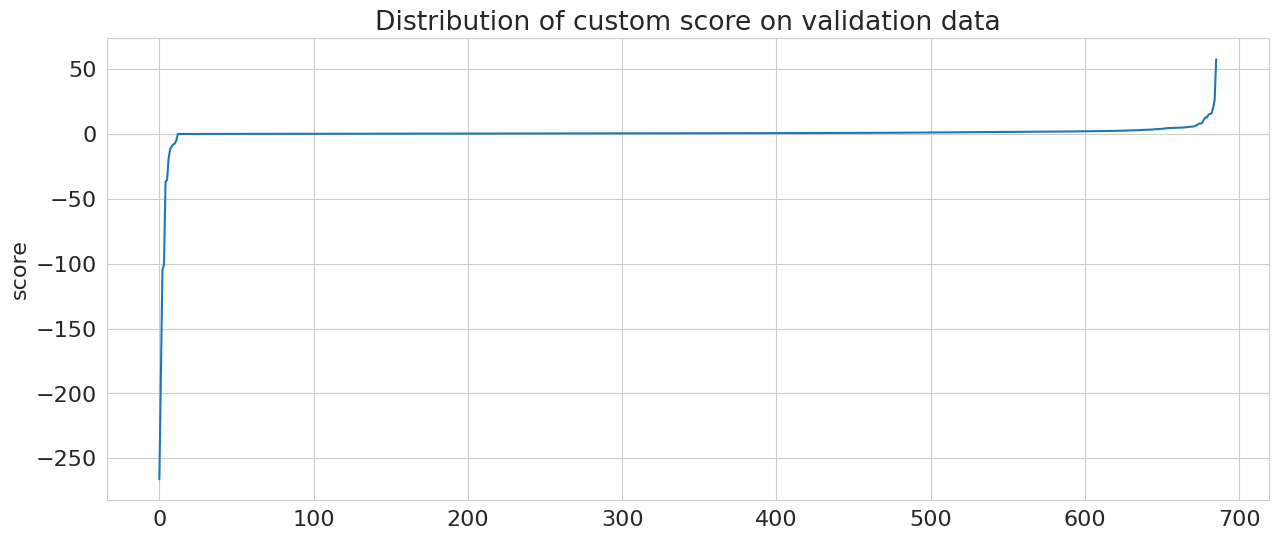

In [9]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(15, 6))
sns.lineplot(x=range(len(df_v_sorted)), y=df_v_sorted['score'])
plt.title('Distribution of custom score on validation data')
plt.show()

In [ ]:
points = df_v.groupby('point') \
             .agg({'lat': 'mean',
                   'lon': 'mean',
                   'score': 'mean'}) \
             .sort_values(by='score')
points_train = df[['point', 'lon', 'lat']].groupby('point') \
                                          .agg({'lon': 'mean',
                                                'lat': 'mean'})

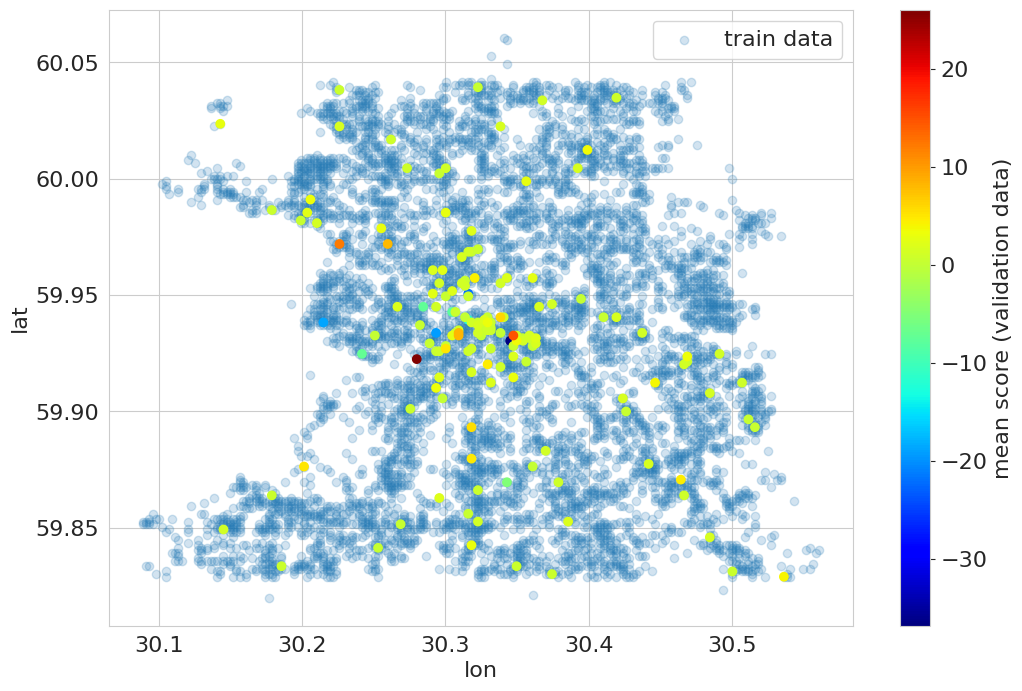

In [11]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(12, 8))
plt.scatter(points_train['lon'], points_train['lat'], alpha=0.2, label='train data')
plt.scatter(points['lon'], points['lat'], c=points['score'], cmap='jet')
plt.ylabel('lat')
plt.xlabel('lon')
plt.legend()
cbar = plt.colorbar(label='mean score (validation data)')

## Best set 3: val: 0.13705165679003126, train: 0.2781595909192343

In [13]:
eval(xgb.XGBRegressor(**best_set3), df, df_v, feats, target)

train R2 = 0.9252559158979212
train custom = 0.2781595909192343
val R2 = -0.302637055444106
val custom = 0.13705165679003126


In [14]:
model = xgb.XGBRegressor(**best_set3)
model.fit(df[feats], df[target])

XGBRegressor(alpha=0.16681005372000587, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.16681005372000587,
             learning_rate=0.8499999999999999, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=800, n_jobs=None, ...)

In [28]:
save_model(model=model, filename='model3.pkl')

In [15]:
df_v['pred'] = model.predict(df_v[feats])
df_v['score'] = np.abs(df_v['pred'] - df_v['count']) / df_v['pred']
df_v_sorted = df_v[['count', 'pred', 'score']].sort_values(by='score')

In [21]:
df_v.to_csv(os.path.join(get_project_dir(), 'data/d2/predictions/predictions3.csv'))

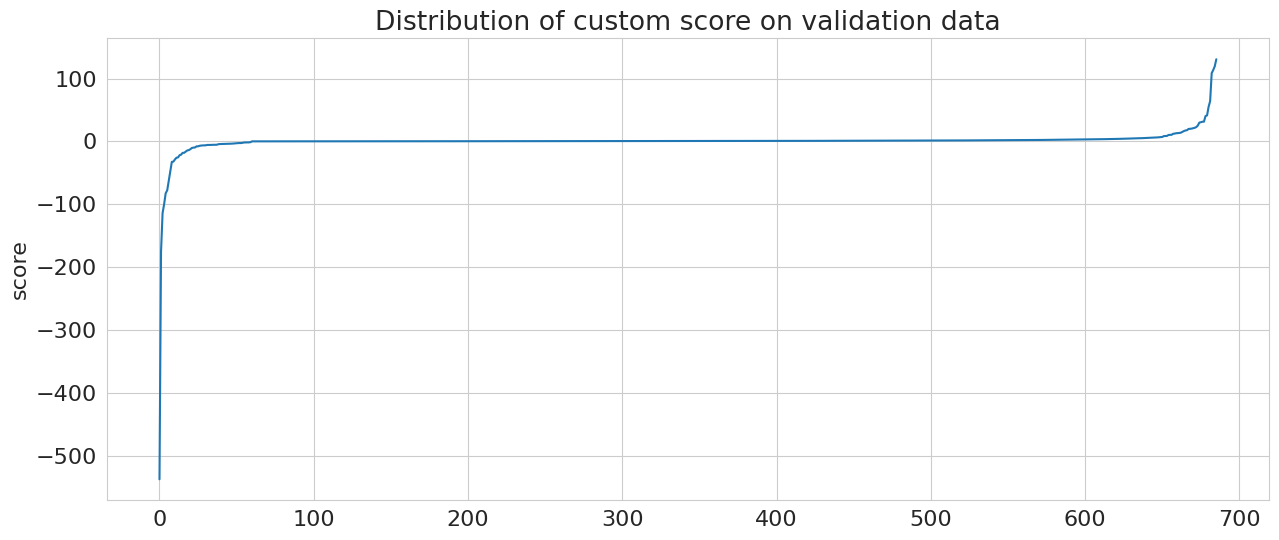

In [16]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(15, 6))
sns.lineplot(x=range(len(df_v_sorted)), y=df_v_sorted['score'])
plt.title('Distribution of custom score on validation data')
plt.show()

In [22]:
points = df_v.groupby('point') \
             .agg({'lat': 'mean',
                   'lon': 'mean',
                   'score': 'mean'}) \
             .sort_values(by='score')
points_train = df[['point', 'lon', 'lat']].groupby('point') \
                                          .agg({'lon': 'mean',
                                                'lat': 'mean'})

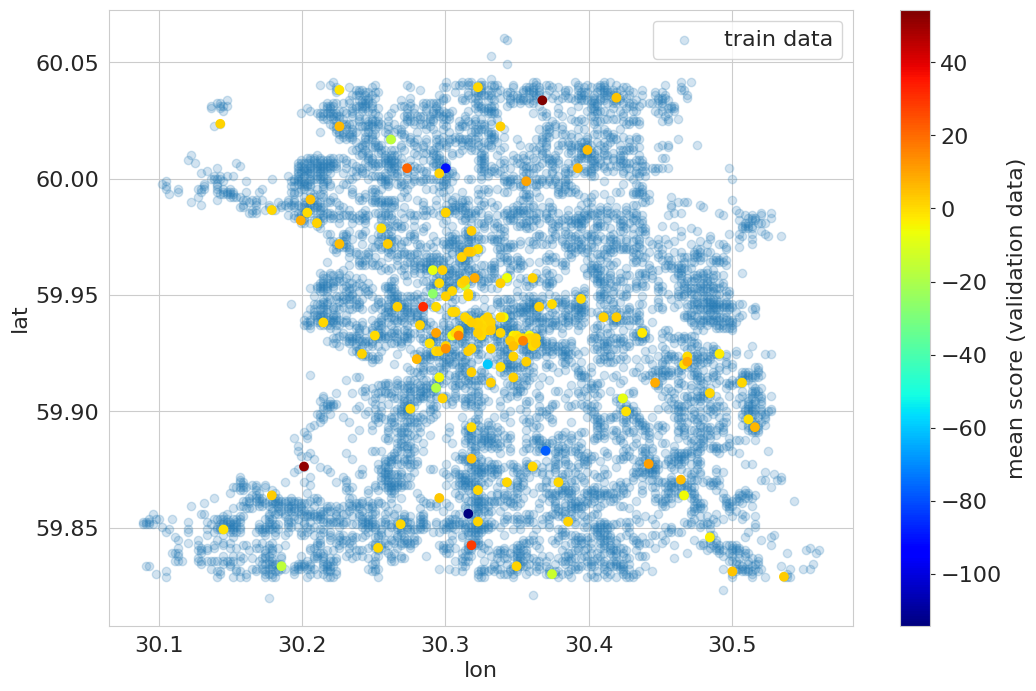

In [23]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(12, 8))
plt.scatter(points_train['lon'], points_train['lat'], alpha=0.2, label='train data')
plt.scatter(points['lon'], points['lat'], c=points['score'], cmap='jet')
plt.ylabel('lat')
plt.xlabel('lon')
plt.legend()
cbar = plt.colorbar(label='mean score (validation data)')